# Cell Division 

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division
from tyssue.core.objects import get_opposite
from tyssue.core.generation import create_anchors

from tyssue.io import hdf5
from tyssue.stores import load_datasets

In [2]:
# h5store = 'before_apoptosis.hf5'
h5store = 'small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
datasets['edge'] = datasets['edge'][['srce', 'trgt', 'face']]
datasets['face'] = datasets['face'][['x', 'y', 'z', 'is_alive']]
datasets['vert'] = datasets['vert'][['x', 'y', 'z']]

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)

# ## Boundary conditions
sheet.vert_df.is_active = 1


# ## Remove dead cells at boundary
boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
for cell in boundary_cells:
    remove_face(sheet, cell)

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)


create_anchors(sheet)
anchor_tension = 0.6

nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
nondim_specs['edge']['anchor_tension'] = anchor_tension
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

geom.update_all(sheet)


In [3]:
sheet.Nf, sheet.Ne, sheet.Nv

(56, 240, 96)

In [4]:
res = solver.find_energy_min(sheet, geom, model)


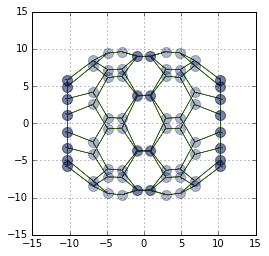

In [5]:
fig, ax = sheet_view(sheet, ['z', 'x'])

In [6]:
from tyssue.core.objects import get_opposite

In [7]:
sheet.edge_df.head()

,at_border,dx,dy,dz,face,is_anchor,length,line_tension,nx,ny,nz,opposite,srce,sub_area,sub_vol,trgt,anchor_tension
edge,,,,,,,,,,,,,,,,,
0,1,-0.885672,4.452605,-1.163656e-10,1,0,4.539836,1410.906092,10.976619,2.183370,-8.314581,-1,78,6.971110,13.465265,64,7054.530459
1,0,2.815497,0.883704,3.458371e+00,1,0,4.546239,1410.906092,10.431803,1.158865,-8.788763,28,64,6.844849,13.221382,2,7054.530459
2,0,-2.615730,1.365984,-3.458371e+00,1,0,4.546239,1410.906092,10.512917,1.411648,-7.393846,196,0,6.464966,31.049324,78,7054.530459
3,0,-1.006258,-3.273749,-1.950951e+00,1,0,3.941598,1410.906092,9.947254,1.262472,-7.249042,201,1,6.186483,33.836269,0,7054.530459
4,0,1.692163,-3.428544,1.950951e+00,1,0,4.292382,1410.906092,9.785027,0.756906,-7.156908,5,2,6.073323,29.168379,1,7054.530459


In [ ]:
ngen = 3
anchors = sheet.edge_df[sheet.edge_df.is_anchor == 1].index

a_srce = sheet.edge_df.loc[anchors, 'srce'].astype(np.int)
a_trgt = sheet.edge_df.loc[anchors, 'trgt'].astype(np.int)

for n in range(ngen):
    live_cells = np.array(sheet.face_df[sheet.face_df.is_alive==1].index)
    np.random.shuffle(live_cells)
    print('Generation {}: {} cells to devide'
         .format(n, len(live_cells)))
    for cell in live_cells:
        V0 = sheet.face_df.loc[cell, 'prefered_vol']
        sheet.face_df.loc[cell, 'prefered_vol'] = 1.5*V0
        daughter = cell_division(sheet, cell, geom, angle=None)
        if daughter is None:
            continue
        sheet.face_df.loc[[cell, daughter],'prefered_vol'] = V0
        res = solver.find_energy_min(sheet, geom, model)
        #isotropic_relax(sheet, nondim_specs)
        sheet.vert_df.loc[a_trgt, sheet.coords] = sheet.vert_df.loc[a_srce, sheet.coords]
        sheet.vert_df.loc[a_trgt, 'z'] += 1e-3
        
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False

fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)

Generation 0: 40 cells to devide


In [13]:
sheet.edge_df.head()

,at_border,dx,dy,dz,face,is_anchor,length,line_tension,nx,ny,nz,opposite,srce,sub_area,sub_vol,trgt,anchor_tension
0,1.0,-0.885672,4.452605,-1.163656e-10,1.0,0.0,4.539836,1410.906092,10.976619,2.183370,-8.314581,-1.0,78.0,6.971110,13.465265,64.0,7054.530459
1,0.0,2.815497,0.883704,3.458371e+00,1.0,0.0,4.546239,1410.906092,10.431803,1.158865,-8.788763,28.0,64.0,6.844849,13.221382,2.0,7054.530459
2,0.0,-2.615730,1.365984,-3.458371e+00,1.0,0.0,4.546239,1410.906092,10.512917,1.411648,-7.393846,196.0,0.0,6.464966,31.049324,78.0,7054.530459
3,0.0,-1.006258,-3.273749,-1.950951e+00,1.0,0.0,3.941598,1410.906092,9.947254,1.262472,-7.249042,201.0,1.0,6.186483,33.836269,0.0,7054.530459
4,0.0,1.692163,-3.428544,1.950951e+00,1.0,0.0,4.292382,1410.906092,9.785027,0.756906,-7.156908,5.0,2.0,6.073323,29.168379,1.0,7054.530459


In [21]:
from tyssue.draw.vispy_draw import vp_view

In [28]:
vp_view(sheet)

In [ ]:
sheet.Nf, sheet.Ne, sheet.Nv

In [ ]:
cell_division(sheet, 23, geom, angle=0)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, ['z', 'x'])

In [ ]:
cell_division(sheet, 15, geom, angle=np.pi/2)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, ['z', 'x'])

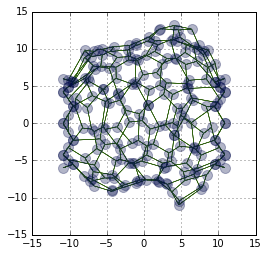

In [6]:
fig, ax = sheet_view(sheet, ['z', 'y'])

In [7]:

vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
